<a href="https://scipp.github.io"><img src="https://scipp.github.io/_static/logo-2022.svg" width="600" /></a>

# Multi-dimensional arrays with labeled dimensions and physical units

## [scipp.github.io](https://scipp.github.io)

In [103]:
%matplotlib inline
import numpy as np
import scipp as sc
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=1234)

In [104]:
def plot(*x):
    """
    Useful plot function for 1d and 2d data
    """
    fig, ax = plt.subplots()
    for a in x:
        if a.ndim == 1:
            ax.plot(np.arange(len(a)), a)
        elif a.ndim == 2:
            ax.imshow(a, origin="lower")

def scatter(x, y):
    """
    Simple scatter plot
    """
    fig, ax = plt.subplots()
    ax.scatter(x, y, marker=".", s=1)
    ax.set_aspect("equal")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    return ax

## 1. Introduction to labeled dimensions: why do we need them?

In [105]:
ny, nx = 10, 20
a = np.sin(np.arange(ny) / (ny / 4)).reshape((-1, 1)) * np.cos(np.arange(nx) / (ny / 4))
a.shape

(10, 20)

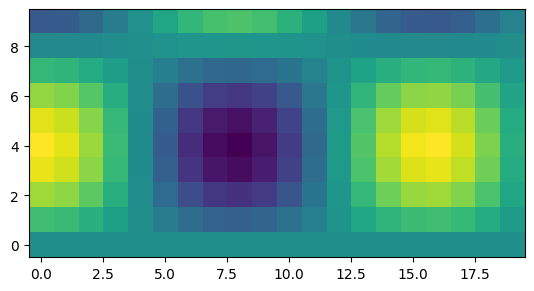

In [106]:
plot(a)

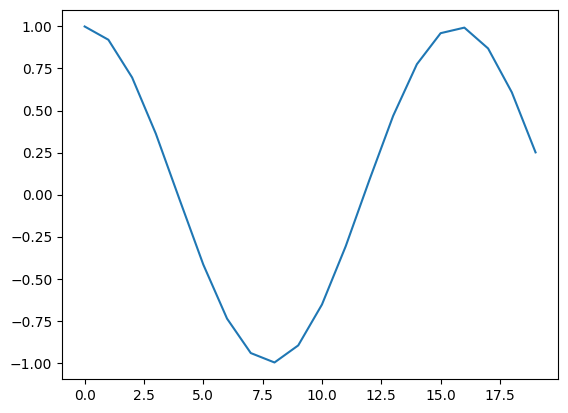

In [107]:
# Slice out row number 4
plot(a[4, :])

### We can't always deduce from the shape

In [108]:
ny, nx = 20, 20
a = np.sin(np.arange(ny) / (ny / 4)).reshape((-1, 1)) * np.cos(np.arange(nx) / (ny / 4))
a.shape

(20, 20)

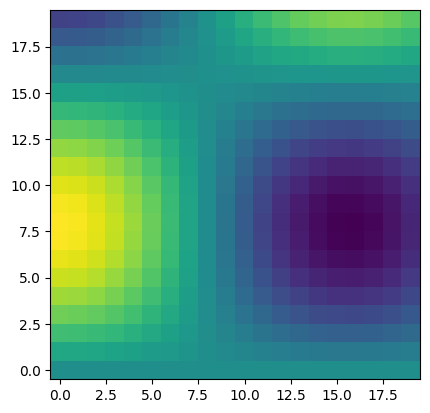

In [109]:
plot(a)

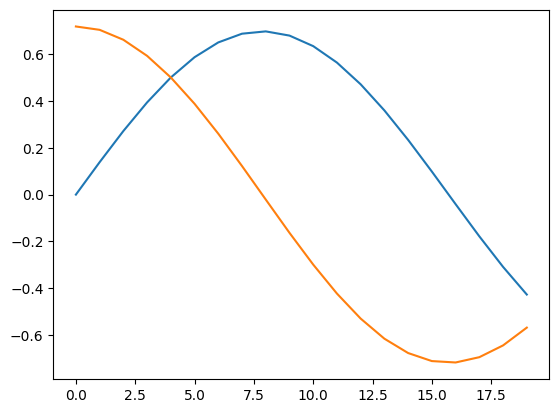

In [110]:
# Not always obvious which dimension is which
plot(a[:, 4], a[4, :])

### The situation gets worse with more dimensions

Say I now have an array that has 4 dimensions: `x, y, z, time` (in that order, maybe?)

In [111]:
a = np.random.random([20] * 4)
a.shape

(20, 20, 20, 20)

I want to get the first `z` slice...

Which one was it again?

In [112]:
z_slice = a[:, :, 0, :]  # x,y,z,t
z_slice = a[0, :, :, :]  # z,y,x,t
z_slice = a[:, :, :, 0]  # t,x,y,z

Quiz: Which one is the 4th `z`, 3rd `x`, 5th `y` between 10th to 15th of `t`?
1. `a[3, 5, 4, 9:15]`
2. `a[9:15, 2, 4, 3]`
3. `a[2, 4, 3, 9:15]`
4. `a[3, 4, 5, 9:15]`

<br><br>

### Introducing labeled dimensions

<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" width="220" /> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <img src="https://scipp.github.io/_static/logo-2022.svg" width="220" />

[Xarray](https://docs.xarray.dev/en/stable/index.html) (https://docs.xarray.dev) introduced labels to multi-dimensional Numpy arrays.

"*real-world datasets are usually more than just raw numbers; they have labels which encode information about how the array values map to locations in space, time, etc.*"

We have embraced, and to a large extent copied, the Xarray mechanism.

In [113]:
var = sc.array(dims=["x", "y", "z", "time"], values=a)
var

<scipp.Variable> (x: 20, y: 20, z: 20, time: 20)    float64  [dimensionless]  [0.505905, 0.488918, ..., 0.184179, 0.961662]

Getting the `z` slice is now easy and **readable**

In [114]:
var["z", 0]

<scipp.Variable> (x: 20, y: 20, time: 20)    float64  [dimensionless]  [0.505905, 0.488918, ..., 0.525575, 0.42599]

Quiz: Which one is the 4th `z`, 3rd `x`, 5th `y` between 10th to 15th of `t`?
1. `a["x", 3]["y", 5]["z", 4]["time", 9:15]`
2. `a["x", 9:15]["y", 2]["z", 4]["time", 9:15]`
3. `a["x", 2]["y", 4]["z", 3]["time", 9:15]`
4. `a["x", 3]["y", 4]["z", 3]["time", 9:15]`

Easy!

<br><br>

### Adding coordinates

- Coordinates can be specified for each dimension.
- They describe the extent of each axis, as well as how far each data point is from its neighbours.

In [12]:
data = sc.array(dims=["space", "time"], values=rng.random((5, 10)))
sc.show(data)

In Scipp and Xarray, coordinates are added in a data structure called `DataArray`:

In [14]:
da = sc.DataArray(
    data=data,
    coords={
        "altitude": sc.linspace("space", 0, 8000, 5),
    },
)
sc.show(da)

In [15]:
da

<scipp.DataArray>
Dimensions: Sizes[space:5, time:10, ]
Coordinates:
* altitude                  float64  [dimensionless]  (space)  [0, 2000, ..., 6000, 8000]
Data:
                            float64  [dimensionless]  (space, time)  [0.873824, 0.350609, ..., 0.588632, 0.503766]

### Exercise 1. Add `year` coordinate `[2000, 2010)` to the `time` dimension.
Each column for all `altitude`s is collected every `year` from 2000 to 2009

**Hint: You can create a ``Variable`` with consecutive numbers by ``sc.arange(dim, start, stop)``.**

In [217]:
da = sc.DataArray(
    data=data,
    coords={
        "year": sc.arange("", 2000, ),
        "altitude": sc.linspace("space", 0, 8000, 5),
    },
)
sc.show(da)
da

**Solution:**

In [29]:
# Try it yourself:


<scipp.DataArray>
Dimensions: Sizes[space:5, time:10, ]
Coordinates:
* altitude                  float64  [dimensionless]  (space)  [0, 2000, ..., 6000, 8000]
* year                        int64  [dimensionless]  (time)  [2000, 2001, ..., 2008, 2009]
Data:
                            float64  [dimensionless]  (space, time)  [0.873824, 0.350609, ..., 0.588632, 0.503766]

### Exercise 2. Add `year` coordinate based on the `scipp-year`.
`scipp-year` was used instead of Gregorian `year` while collecting data.
Please add Gregorian `year` coordinate.
> Hint: First `scipp` was released in 2020.

In [39]:
da = sc.DataArray(
    data= sc.array(dims=["space", "time"], values=rng.random((5, 24))),
    coords={
        "scipp-year": sc.arange("time", -20, 4),
        "altitude": sc.linspace("space", 0, 80000, 5)
    },
)
sc.show(da)
da

<scipp.DataArray>
Dimensions: Sizes[space:5, time:24, ]
Coordinates:
* altitude                  float64  [dimensionless]  (space)  [0, 20000, ..., 60000, 80000]
* scipp-year                  int64  [dimensionless]  (time)  [-20, -19, ..., 2, 3]
Data:
                            float64  [dimensionless]  (space, time)  [0.330178, 0.542599, ..., 0.849807, 0.853451]

**Solution:**

In [40]:
# Try it yourself:


<scipp.DataArray>
Dimensions: Sizes[space:5, time:24, ]
Coordinates:
* altitude                  float64  [dimensionless]  (space)  [0, 20000, ..., 60000, 80000]
* scipp-year                  int64  [dimensionless]  (time)  [-20, -19, ..., 2, 3]
* year                        int64  [dimensionless]  (time)  [2000, 2001, ..., 2022, 2023]
Data:
                            float64  [dimensionless]  (space, time)  [0.330178, 0.542599, ..., 0.849807, 0.853451]

**Hint:**

In [218]:
da.coords['year'] = da.coords['scipp-year'] + 
sc.show(da)
da

<br><br>

## 2. Going further

<img src="https://scipp.github.io/_static/logo-2022.svg" width="220" />

### 2.1 Physical units

Every data variable and coordinate in Scipp has physical units.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(see also [pint](https://pint.readthedocs.io/en/stable/), [astropy.units](https://docs.astropy.org/en/stable/units/index.html), [pint-xarray](https://pint-xarray.readthedocs.io/en/stable/), ...)

In [219]:
x = sc.array(dims=['row'], values=rng.normal(size=10000), unit='cm')
y = sc.array(dims=['row'], values=rng.normal(size=10000), unit='cm')
recording = sc.DataArray(data=sc.ones(sizes=x.sizes, unit='counts'),
                         coords={'x': x, 'y': y})
image = recording.hist(y=100, x=100)
image

<scipp.DataArray>
Dimensions: Sizes[y:100, x:100, ]
Coordinates:
* x                         float64             [cm]  (x [bin-edge])  [-4.20188, -4.12036, ..., 3.8681, 3.94962]
* y                         float64             [cm]  (y [bin-edge])  [-4.12423, -4.04602, ..., 3.61783, 3.69604]
Data:
                            float64         [counts]  (y, x)  [0, 0, ..., 0, 0]

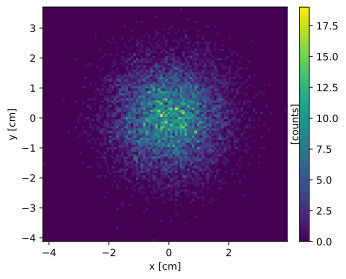

In [220]:
image.plot(aspect="equal")

counts/s


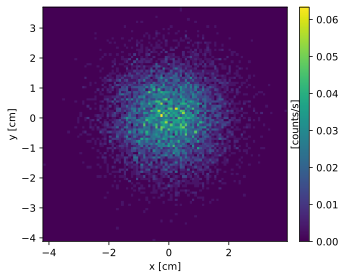

In [221]:
integration_time = sc.scalar(300.0, unit="s")
image /= integration_time
print(image.unit)

image.plot(aspect="equal")

<br><br>

### Units also provide protection

Say I now have a background image (dark frame) which I want to subtract from the signal image above,
but I forgot to first normalize it by integration time

In [224]:
background = sc.array(dims=["y", "x"], values=rng.random((100, 100)), unit="counts")

image - background

UnitError: Cannot subtract counts/s and counts.

In [225]:
background_integration_time = sc.scalar(60.0, unit="s")
background /= background_integration_time

background_subtracted = image - background

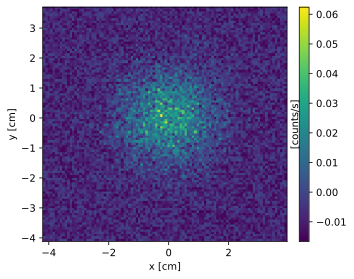

In [226]:
background_subtracted.plot(aspect="equal")

- The units are very useful in early prevention of difficult-to-spot bugs in a workflow.
- They save **hours** of debugging time, free-up mental capacity and let the user focus on the important thing: **doing science**.

<br><br>

### Units for label-based indexing

We also use units to distinguish between positional indexing and label-based indexing:

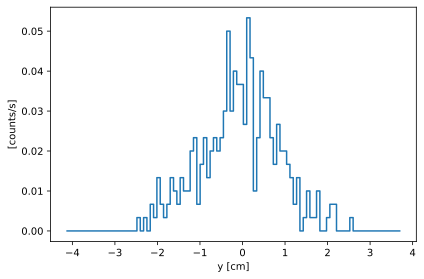

In [227]:
image['x', 0.5 * sc.Unit('cm')].plot()

Positional index is based on the `dimension`, and the value index is based on the `coordinates`.

In [228]:
da = sc.DataArray(
    data=sc.array(dims=["space", "time"], values=rng.random((5, 9))),
    coords={
        "time": sc.arange("time", 19, 28, unit='s'),
        "altitude": sc.linspace("space", 0, 800, 5, unit='m')
    },
)
sc.show(da)
da

<scipp.DataArray>
Dimensions: Sizes[space:5, time:9, ]
Coordinates:
* altitude                  float64              [m]  (space)  [0, 200, ..., 600, 800]
* time                        int64              [s]  (time)  [19, 20, ..., 26, 27]
Data:
                            float64  [dimensionless]  (space, time)  [0.850112, 0.0877538, ..., 0.884702, 0.249634]

We want to select the data where the `time` is `20` seconds.

In [229]:
da.coords['time']  # 20 seconds is the 1-st value of the `time` coordinate.

<scipp.Variable> (time: 9)      int64              [s]  [19, 20, ..., 26, 27]

So we can select the 1st slice of `time` dimension.

In [230]:
da['time', 1]

<scipp.DataArray>
Dimensions: Sizes[space:5, ]
Coordinates:
* altitude                  float64              [m]  (space)  [0, 200, ..., 600, 800]
  time                        int64              [s]  ()  20
Data:
                            float64  [dimensionless]  (space)  [0.0877538, 0.507764, ..., 0.0299505, 0.769866]

But instead, we can use `unit` for selecting the data corresponding to the `time` of `20` seconds.

In [231]:
da['time', sc.scalar(20, unit='s')]

<scipp.DataArray>
Dimensions: Sizes[space:5, ]
Coordinates:
* altitude                  float64              [m]  (space)  [0, 200, ..., 600, 800]
  time                        int64              [s]  ()  20
Data:
                            float64  [dimensionless]  (space)  [0.0877538, 0.507764, ..., 0.0299505, 0.769866]

Quiz. Which ones are selecting the data slice where `altitude` is `600 m`? (Multiple choices)

1. da['altitude', 3]
2. da['space', 3]
3. da['altitude', sc.scalar(600, unit='m')]
4. da['space', sc.scalar(600, unit='m')]

You can also use it for selecting a range.

In [232]:
da['time', sc.scalar(20, unit='s'):sc.scalar(24, unit='s')]

<scipp.DataArray>
Dimensions: Sizes[space:5, time:4, ]
Coordinates:
* altitude                  float64              [m]  (space)  [0, 200, ..., 600, 800]
* time                        int64              [s]  (time)  [20, 21, 22, 23]
Data:
                            float64  [dimensionless]  (space, time)  [0.0877538, 0.391575, ..., 0.404621, 0.222744]

Quiz. Which ones are selecting the data slice where `altitude` is between `300 m` to `700 m`? (Multiple choices)

1. da['altitude', 2:4]
2. da['space', 2:4]
3. da['altitude', sc.scalar(300, unit='m'):sc.scalar(700, unit='m')]
4. da['space', sc.scalar(300, unit='m'):sc.scalar(700, unit='m')]

### Exercise 3. Coordinate and Units

Instead of `altitude`, we want to use `pressure` coordinate for `space` dimension.

Here is the incomplete function `altitude_to_pressure` that converts `altitude[m]` into `pressure[hPa]`.

Complete the function and use it to add the `pressure` coordinate.

In [235]:
def altitude_to_pressure(altitude):
    p_b = sc.scalar(1013.25, unit='hPa')
    return p_b*(sc.scalar(1) - altitude/sc.scalar(44307, unit=''))**5

da.coords['pressure'] = altitude_to_pressure(da.coords['altitude'])
da

Now we can drop the unecessary coordinate, `altitude`.

In [236]:
da = da.drop_coords(['altitude'])
da

<scipp.DataArray>
Dimensions: Sizes[space:5, time:9, ]
Coordinates:
* time                        int64              [s]  (time)  [19, 20, ..., 26, 27]
Data:
                            float64  [dimensionless]  (space, time)  [0.850112, 0.0877538, ..., 0.884702, 0.249634]

<br><br>

### 2.2 Bin-edge coordinates

- It is sometimes necessary to have coordinates that represent a range for each data value.
- E.g. "the temperature was 310 K in the time span between 10 and 20 seconds".
- This also arises every time we histogram data, as in the image above.
- Scipp supports this by having **bin-edge coordinates**: a coordinate which has a length of 1 more than the dimension length.

In [237]:
image = recording.hist(y=8, x=8)
sc.show(image)

In [238]:
image

<scipp.DataArray>
Dimensions: Sizes[y:8, x:8, ]
Coordinates:
* x                         float64             [cm]  (x [bin-edge])  [-4.20188, -3.18294, ..., 2.93068, 3.94962]
* y                         float64             [cm]  (y [bin-edge])  [-4.12423, -3.14669, ..., 2.7185, 3.69604]
Data:
                            float64         [counts]  (y, x)  [0, 0, ..., 0, 0]

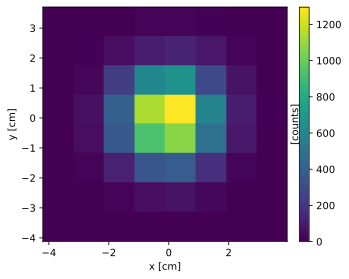

In [239]:
image.plot(aspect='equal')

- Numpy and Matplotlib return the bin edges and the data counts separately
- We have everything stored inside a single data structure

### Exercise 4. Bin-edge coordinates and Units

We would like to investigate data by subtracting `background` from `recording`.

Here is the collected data `recording`.

In [241]:
b_x = sc.array(dims=['row'], values=rng.normal(size=100000-200), unit='cm')
b_y = sc.array(dims=['row'], values=rng.normal(size=100000-200), unit='cm')

x1 = rng.random(size=100)*2 + 2
x2 = rng.random(size=100)*2 + 2
y1 = (np.sqrt(1 - (np.abs(x1-3)*2 - 1)**2))/3 - 2
y2 = (np.arccos(1-np.abs(x2-3)*2) - 3.14)/3 - 2
s_x = sc.array(dims=['row'], values = np.concatenate((x1, x2)), unit='cm')
s_y = sc.array(dims=['row'], values = np.concatenate((y1, y2)), unit='cm')

x = sc.concat([s_x, b_x], dim='row')
y = sc.concat([s_y, b_y], dim='row')

recording = sc.DataArray(data=sc.ones(sizes=x.sizes, unit='counts'),
                         coords={'x': x, 'y': y})

In [246]:
recording

<scipp.DataArray>
Dimensions: Sizes[row:100000, ]
Coordinates:
* x                         float64             [cm]  (row)  [2.18697, 3.30029, ..., -0.213133, 0.00239616]
* y                         float64             [cm]  (row)  [-1.74007, -1.69441, ..., 0.737014, -1.58025]
Data:
                            float64         [counts]  (row)  [1, 1, ..., 1, 1]

And the `recording` was collected for `recording_time` seconds.

In [248]:
recording_time = sc.scalar(100000, unit='s')
recording_time

<scipp.Variable> ()      int64              [s]  100000

#### 4-1. First, we want to make a 100 by 100 histogram of the `recording` per second.

**Hint:**

In [250]:
signal = recording.hist(y=, x=)/recording_time
signal.plot(aspect='equal')

**Solution:**

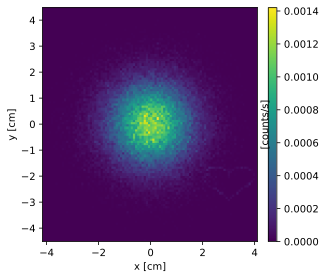

In [265]:
# Try it yourself:


#### 4-2. Let's substract `background` from the `signal`. `background` was collected for `50,000` seconds.

In [272]:
b_x = sc.array(dims=['row'], values=rng.normal(size=50_000), unit='cm')
b_y = sc.array(dims=['row'], values=rng.normal(size=50_000), unit='cm')

bg_recording = sc.DataArray(data=sc.ones(sizes=b_x.sizes, unit='counts'),
                          coords={'x': b_x, 'y': b_y})
bg_recording

<scipp.DataArray>
Dimensions: Sizes[row:50000, ]
Coordinates:
* x                         float64             [cm]  (row)  [-1.37145, 0.101151, ..., 2.21426, -0.812615]
* y                         float64             [cm]  (row)  [0.625712, 0.77589, ..., -1.88544, -2.23046]
Data:
                            float64         [counts]  (row)  [1, 1, ..., 1, 1]

**Hint:**

In [278]:
background_recording_time = sc.scalar( , unit='s')

background = bg_recording.hist(y=signal.coords[''], x=signal.coords[''])
background /= background_recording_time

subtracted = signal - background
subtracted.plot(aspect='equal')

**Solution:**

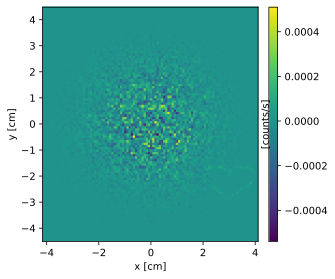

In [277]:
# Try it yourself:


<br><br>

## 3. Binned data

Scipp distinguishes **histogrammed** data from **binned** data:

- Histogrammed data refers to regular dense arrays of, e.g., floating-point values with an associated bin-edge coordinate.
- Binned data refers to the precursor of histogrammed data, i.e., each bin contains a “list” of contributing events or values. Binned data can be converted into a histogram by computing the sum over all events or values in a bin.

<!-- 
TODO: Add image file.
<img src="binned_drawing.svg" />
-->

This is conceptually similar to a multi-dimensional <a href="https://awkward-array.org/doc/main/"><img src="https://iris-hep.org/assets/logos/awkward.svg" width="100" /></a>.

It is best illustrated with an example of data analysis.
For this, we will use one of the NYC taxi datasets.

<br><br>

### NYC yellow taxi dataset

<img src="https://vaex.readthedocs.io/en/latest/_images/datasets_2_1.png" /> <img src="https://cdn-images-1.medium.com/v2/resize:fit:2680/1*fqrY2h4uLD3eKEvJ6hlI2g.png" width="600" />

(https://vaex.readthedocs.io/en/latest/datasets.html, Dataset from 2015, obtained as a HDF5 file from the Vaex docs,
and subsequently cleaned of outliers).

In [ ]:
%matplotlib widget

da = sc.io.load_hdf5('nyc_taxi_data_2015.h5')
da

In [ ]:
n = 1000
x = da.coords["longitude"].values[::n]
y = da.coords["latitude"].values[::n]
scatter(x, y)

### Binning the data records

- Working with binned data is most efficient when keeping the number of bins relatively low.
- Binning is essentially like overlaying a grid of bin edges onto our data

In [ ]:
ax = scatter(x, y)
for lon in np.linspace(*ax.get_xlim(), 9):
    ax.axvline(lon, color="gray")
for lat in np.linspace(*ax.get_ylim(), 9):
    ax.axhline(lat, color="gray")

In [ ]:
# Bin into 8 longitude & latitude bins
binned = da.bin(latitude=8, longitude=8)
binned

In [ ]:
# Histogramming is summing all the counts in each bin
binned.hist().plot(aspect="equal", norm="log")

<br><br>

### Selecting/slicing bins

- Binning *groups* the data into bins, but keeps the underlying table of records beneath
- **No information is lost, it is simply re-ordered**
- The bins can then be used for slicing the data, providing extremely efficient data selection and filtering

In [ ]:
manh = binned["longitude", 1]["latitude", 4]
manh

In [ ]:
# We can now histogram this with a much finer resolution

manh.hist(latitude=300, longitude=300).plot(norm="log", aspect="equal")

In [ ]:
# We select another bin, which contains the JFK airport

jfk = binned["longitude", 6]["latitude", 1]
jfk.hist(latitude=300, longitude=300).plot(norm="log", aspect="equal")

![jfk](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/JFK_airport_terminal_map.png/640px-JFK_airport_terminal_map.png)

(https://commons.wikimedia.org/wiki/File:JFK_airport_terminal_map.png)

<br><br>

### Binning into a new dimension

- Data that has already been binned can also be binned further into new dimensions

In [ ]:
manh

- we look at the trip distances inside the Manhattan and JFK bins we have selected above.

In [ ]:
# Use 100 distance bins
manh_dist = manh.bin(trip_distance=100)
manh_dist

In [ ]:
manh_dist.hist().plot()

In [ ]:
jfk_dist = jfk.bin(trip_distance=100)
jfk_dist.hist().plot()

<br><br>


### Other operations on bins: what is the fare amount as a function of distance?

- In addition to summing/histogramming, bins can be used for other reduction operations: `min()`, `max()`, and `mean()`.

In [ ]:
manh_dist

- To get the minimum and maximum fares for all trips that ended inside our Manhattan area, we can do

In [ ]:
manh_dist.bins.coords['fare_amount'].min(), manh.bins.coords['fare_amount'].max()

- These values are somewhat strange, indicative of bad data in the table.
- We restrict our fare range from \\$0 to \\$200.

In [ ]:
# Make 100 bins between 0 and 200 dollars
nbins = 100
fare_bins = sc.linspace('fare_amount', 0, 200, nbins + 1, unit='dollar')

# Bin & plot our data
manh_dist.bin(fare_amount=fare_bins).hist().transpose().plot(norm="log")

Some things we can say about the data:

- there appears to be a (somewhat expected) correlation between fare amount and trip distance: the further you go, the more you'll have to pay
- for a given trip distance, clients usually pay above the diagonal line, rarely below
- there appears to be a magic fare amount of \\$52 that will take you anywhere from 0 to 60 miles!

<br><br>

## 4. Plopp: interactive data visualization tools

<img src="https://scipp.github.io/plopp/_static/logo.svg" width="200" />

https://scipp.github.io/plopp 

In [ ]:
import plopp as pp

fare_lat_lon = da.hist(fare_amount=fare_bins, latitude=300, longitude=300)
fare_lat_lon

In [ ]:
pp.inspector(fare_lat_lon, dim='fare_amount', norm='log')

### Final Exercise.